In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.optim.lr_scheduler import ExponentialLR

In [33]:
# data = pd.read_csv("heart_failure_clinical_records_dataset.csv")
data = pd.read_csv("heart_failure_clinical_records_dataset.csv")

# Separate features and target variable
X = data.drop(columns=["DEATH_EVENT"])
y = data["DEATH_EVENT"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Acceptable Model of weight_tuning_LG_UA :

In [37]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets and data loaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        init.xavier_uniform_(self.fc1.weight)  # Xavier initialization for weights of fc1
        self.bn = nn.BatchNorm1d(hidden_size)  # Batch normalization layer
        self.fc2 = nn.Linear(hidden_size, 1)
        init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn(x)  # Applying batch normalization
        x = F.relu(x)  # Using ReLU activation function
        x = self.fc2(x)
        return x

def calculate_loss(model, criterion, inputs, labels):
    outputs = model(inputs).squeeze()
    loss = criterion(outputs, labels.float())
    return loss

input_size = X_train_tensor.shape[1]
hidden_size = 8
model2 = NeuralNetwork(input_size, hidden_size)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.95)

# Define the error value criterion
error_criterion = 0.3
n = 0.01

training_stopped = False

while not training_stopped:
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        original_loss = calculate_loss(model2, criterion, inputs, labels)

        print("Original Loss:", original_loss.item())

        # Check if the loss is smaller than the error value criterion
        if original_loss.item() < error_criterion:
            print("An acceptable 2LNN")
            training_stopped = True
            break

        original_loss.backward()
        optimizer.step()

        with torch.no_grad():
            for param in model2.parameters():
                if param.requires_grad:
                    original_param = param.clone()
                    param -= n * param.grad

            new_loss = calculate_loss(model2, criterion, inputs, labels)

            if new_loss.item() < original_loss.item():
                n *= 1.2
                print("New weight accepted, updated learning rate: ", n)
                break
            else:
                if n > 0.001:
                    n *= 0.7
                    print("New weight rejected, updated learning rate: ", n)
                else:
                    print("An unacceptable 2LNN")
                    training_stopped = True
                    break

    if original_loss.item() < error_criterion:
        break
    if training_stopped:
        break

Original Loss: 0.7928974628448486
New weight accepted, updated learning rate:  0.012
Original Loss: 0.7061982154846191
New weight accepted, updated learning rate:  0.0144
Original Loss: 0.7082386612892151
New weight accepted, updated learning rate:  0.01728
Original Loss: 0.6955766677856445
New weight accepted, updated learning rate:  0.020736
Original Loss: 0.5828512907028198
New weight accepted, updated learning rate:  0.0248832
Original Loss: 0.6017258763313293
New weight accepted, updated learning rate:  0.02985984
Original Loss: 0.6291185021400452
New weight accepted, updated learning rate:  0.035831808
Original Loss: 0.623953640460968
New weight accepted, updated learning rate:  0.0429981696
Original Loss: 0.5467280149459839
New weight accepted, updated learning rate:  0.05159780351999999
Original Loss: 0.5824074149131775
New weight accepted, updated learning rate:  0.06191736422399999
Original Loss: 0.5541133284568787
New weight accepted, updated learning rate:  0.07430083706879

In [38]:
model_path = "accepable_model_LG_UA.pth"

# Save the final model's parameters
torch.save(model2.state_dict(), model_path)
print(f"Model parameters saved to {model_path}")

# Load the saved model parameters to continue training
loaded_model2 = NeuralNetwork(input_size, hidden_size)
loaded_model2.load_state_dict(torch.load(model_path))
print("Model parameters loaded from", model_path)

Model parameters saved to accepable_model_LG_UA.pth
Model parameters loaded from accepable_model_LG_UA.pth


## Network Tuning: Regularizing_LG_UA + examine all for potentially irrelevant node

In [43]:
# Define the error value criterion
error_criterion = 0.3
n = 0.01
l2_lambda = 0.01
training_stopped = False

# Regularization and UA process
while not training_stopped:
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = loaded_model2(inputs).squeeze()
        original_loss = criterion(outputs, labels.float())

        # Calculate L2 regularization term
        l2_reg = torch.tensor(0., requires_grad=True)
        for param in loaded_model2.parameters():
            l2_reg = l2_reg + torch.norm(param, 2)

        # Add L2 regularization to the loss function
        loss_with_l2 = original_loss + l2_lambda * l2_reg

        print("Original Loss with L2 regularization:", loss_with_l2.item())

        loss_with_l2.backward()
        optimizer.step()

        # Reset l2_reg to zero for the next iteration
        l2_reg = torch.tensor(0., requires_grad=True)

        with torch.no_grad():
            for param in loaded_model2.parameters():
                if param.requires_grad:
                    param -= n * param.grad

            new_loss = criterion(loaded_model2(inputs).squeeze(), labels.float())

            if new_loss.item() < loss_with_l2.item():
                # Check if the loss is smaller than the error value criterion
                if loss_with_l2.item() < error_criterion:
                    n *= 1.2
                    print("New weight accepted, updated learning rate: ", n)
                    break
                else:
                    print("An unacceptable 2LNN")
                    training_stopped = True
                    loaded_model2.load_state_dict(torch.load(model_path))
                    print("Restored model parameters from", model_path)
                    break
            else:
                if n > 0.001:
                    n *= 0.7
                    print("New weight rejected, updated learning rate: ", n)
                else:
                    print("An unacceptable 2LNN")
                    training_stopped = True
                    loaded_model2.load_state_dict(torch.load(model_path))
                    print("Restored model parameters from", model_path)
                    break

    if loss_with_l2.item() < error_criterion:
        break
    if training_stopped:
        break

# Function to evaluate the model
def evaluate_model(model, loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            total_loss += loss.item()
    return total_loss / len(loader)

# Function to fine-tune the model for a specified number of epochs
def fine_tune_model(model, train_loader, epochs=50):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
        scheduler.step()


# Load the regularized model into model1 for pruning process
final_model = NeuralNetwork(input_size, hidden_size)
final_model.load_state_dict(loaded_model2.state_dict())

# Check initial performance
initial_loss = evaluate_model(final_model, test_loader)
print(f"Initial Test Loss: {initial_loss:.4f}")

# Pruning process
k = 0
p = hidden_size

while k < p:
    # Save the current state of the model's fc1 and fc2 layers
    original_fc1_weight = final_model.fc1.weight.clone()
    original_fc1_bias = final_model.fc1.bias.clone()
    original_fc2_weight = final_model.fc2.weight.clone()

    # Zero out the weights and biases of the k-th hidden node
    final_model.fc1.weight.data[k, :] = 0
    final_model.fc1.bias.data[k] = 0
    final_model.fc2.weight.data[:, k] = 0

    # Fine-tune the model after removing the node
    fine_tune_model(final_model, train_loader, epochs=50)

    # Evaluate the modified model
    new_loss = evaluate_model(final_model, test_loader)
    print(f"New Test Loss after masking node {k+1}: {new_loss:.4f}")

    if new_loss < 0.1:
        # Node is irrelevant, continue with reduced model
        p -= 1
        # Remove the k-th node by keeping the zeroed weights
        # Shift the remaining weights and biases in fc1 and fc2
        with torch.no_grad():
            final_model.fc1.weight = nn.Parameter(torch.cat((final_model.fc1.weight[:k], final_model.fc1.weight[k+1:])))
            final_model.fc1.bias = nn.Parameter(torch.cat((final_model.fc1.bias[:k], final_model.fc1.bias[k+1:])))
            final_model.fc2.weight = nn.Parameter(torch.cat((final_model.fc2.weight[:, :k],final_model.fc2.weight[:, k+1:]), dim=1))

            # If you have batch norm layers, adjust their running statistics here:
            # Assuming you have batch norm layers named `bn1` and `bn2`
            # Adjust running_mean and running_var of batch norm layers
            if hasattr(final_model, 'bn1'):
                final_model.bn1.running_mean = final_model.bn1.running_mean[:p]
                final_model.bn1.running_var = final_model.bn1.running_var[:p]
            if hasattr(final_model, 'bn2'):
                final_model.bn2.running_mean = final_model.bn2.running_mean[:p]
                final_model.bn2.running_var = final_model.bn2.running_var[:p]

    else:
        # Node is relevant, restore original weights and biases
        final_model.fc1.weight.data = original_fc1_weight
        final_model.fc1.bias.data = original_fc1_bias
        final_model.fc2.weight.data = original_fc2_weight
        k += 1



Original Loss with L2 regularization: 0.40716955065727234
An unacceptable 2LNN
Restored model parameters from accepable_model_LG_UA.pth
Initial Test Loss: 0.5731
New Test Loss after masking node 1: 0.5678
New Test Loss after masking node 2: 0.5620
New Test Loss after masking node 3: 0.6290
New Test Loss after masking node 4: 0.5292
New Test Loss after masking node 5: 0.6174
New Test Loss after masking node 6: 0.5541
New Test Loss after masking node 7: 0.5080
New Test Loss after masking node 8: 0.5355


In [44]:
# Drop the 1st, 2nd, and 7th nodes (indices 0, 1, and 6)
drop_nodes = [0, 1, 6]

with torch.no_grad():
    final_model.fc1.weight.data = torch.cat([final_model.fc1.weight.data[:drop_nodes[0]], final_model.fc1.weight.data[drop_nodes[0]+1:]])
    final_model.fc1.bias.data = torch.cat([final_model.fc1.bias.data[:drop_nodes[0]], final_model.fc1.bias.data[drop_nodes[0]+1:]])
    final_model.fc2.weight.data = torch.cat([final_model.fc2.weight.data[:, :drop_nodes[0]], final_model.fc2.weight.data[:, drop_nodes[0]+1:]], dim=1)

    drop_nodes = [index - 1 for index in drop_nodes[1:]]

    final_model.fc1.weight.data = torch.cat([final_model.fc1.weight.data[:drop_nodes[0]], final_model.fc1.weight.data[drop_nodes[0]+1:]])
    final_model.fc1.bias.data = torch.cat([final_model.fc1.bias.data[:drop_nodes[0]], final_model.fc1.bias.data[drop_nodes[0]+1:]])
    final_model.fc2.weight.data = torch.cat([final_model.fc2.weight.data[:, :drop_nodes[0]], final_model.fc2.weight.data[:, drop_nodes[0]+1:]], dim=1)

    drop_nodes = [index - 1 for index in drop_nodes[1:]]

    final_model.fc1.weight.data = torch.cat([final_model.fc1.weight.data[:drop_nodes[0]], final_model.fc1.weight.data[drop_nodes[0]+1:]])
    final_model.fc1.bias.data = torch.cat([final_model.fc1.bias.data[:drop_nodes[0]], final_model.fc1.bias.data[drop_nodes[0]+1:]])
    final_model.fc2.weight.data = torch.cat([final_model.fc2.weight.data[:, :drop_nodes[0]], final_model.fc2.weight.data[:, drop_nodes[0]+1:]], dim=1)

print("An acceptable 2LNN")

# Print the number of remaining hidden nodes
remaining_nodes = final_model.fc1.weight.shape[0]
print(f"Number of remaining hidden nodes: {remaining_nodes}")

# Save the final pruned model mask
torch.save(final_model.state_dict(), "pruned_model_mask.pth")
print(f"Final pruned model parameters saved to pruned_model_mask.pth")

An acceptable 2LNN
Number of remaining hidden nodes: 5
Final pruned model parameters saved to pruned_model_mask.pth


In [48]:
# Set the model to evaluation mode
final_model.eval()

# Evaluate the performance on the test set
with torch.no_grad():
    outputs = final_model(X_test_tensor).squeeze()  # Remove the extra dimension
    predicted = (outputs >= 0.5).float()  # Applying threshold of 0.5 for binary classification
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Test Accuracy: {accuracy}')

RuntimeError: running_mean should contain 5 elements not 8

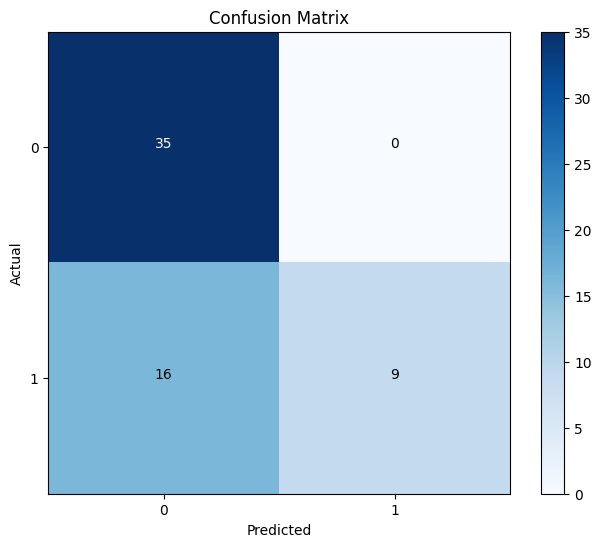

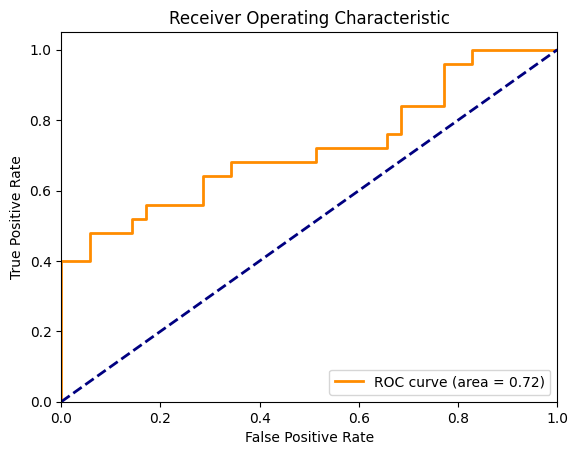

In [14]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test_tensor.numpy(), predicted.numpy())
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_tensor.numpy(), outputs.numpy())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()